# Comparison of Computing `traceinv` on CPU vs GPU


### Objective

Compares $\mathrm{trace}(\mathbf{A}^{-1})$ using three algorithms:

* **CPU**
* **GPU**

This notebook will plot

* Process time of each method.
* Accuracy of computing traceinv wth respect to 128-bit data type.

### Matrices

Matrix $\mathbf{A}$ are symmetric positive-definite matrices from real applications obtained from [sparsesuite matrix collection](https://sparse.tamu.edu/).

* ['nos5'](https://sparse.tamu.edu/HB/nos5)
* ['mhd4800b'](https://sparse.tamu.edu/Bai/mhd4800b)
* ['bodyy6'](https://sparse.tamu.edu/Pothen/bodyy6)
* ['G2_circuit'](https://sparse.tamu.edu/AMD/G2_circuit)
* ['parabolic_fem'](https://sparse.tamu.edu/Wissgott/parabolic_fem)
* ['StocF-1465'](https://sparse.tamu.edu/Janna/StocF-1465)
* ['Bump_2911'](https://sparse.tamu.edu/Janna/Bump_2911)
* ['Queen_4147'](https://sparse.tamu.edu/Janna/Queen_4147): This matrix is so large that 32-bit integers cannot hold the indices of this matrix. Rather, 32-bit `unsigned int` should be used.


### Consideratons

**parameters:**
* In SLQ and Hutchinson methods, `min_num_samples` and `max_num_samples` are fixed to 200.
* In SLQ method, `lanczos_degree` is 80. Lanczos degree of 50 is no enough.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.
* The GPU results are obtained by GTX-3090 GPUs in [Genesis Cloud](https://www.genesiscloud.com/).

**Notes:**

* CPU computations have all 32, 64, and 128 but data types.
* GPU computations have ony 32, and 64 data types.


### How to run the code

Run the code both on CPU and GPU as follows.

#### 1.1. Run on local CPU

Run `/benchmark/scripts/benchmark_speed.py` by

    cd /benchmark/scripts
    python ./benchmark_speed.py -c
    
where `-c` runs the code on CPU on all 32-bit, 64-bit, and 128-bit data types.

The output is stored in `/benchnmark/pickle_results/benchmark_results_cpu.pickle`. Rename the results on CPU to

    /benchmark/pickle_results/benchmark_results_cpu_2670v3.pickle

#### 1. 2. Run on CPU cluster

To run this script on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_benchmark_speed_cpu.sh
   
When submitting the jobs, make sure that the cpu is the same as the previous runs. For isnatnce, nodes on savio2 cluster between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

#### 2.1. Run on local GPU

Run `/benchmark/scripts/benchmark_speed.py` by

    cd /benchmark/scripts
    module load cuda/11.2
    python ./benchmark_speed.py -g
    
where `-g` runs the code on CPU on all 32-bit, 64-bit, and 128-bit data types.

The output is stored in `/benchnmark/pickle_results/benchmark_results_cpu.pickle`. Rename the results to

    /benchmark/pickle_results/benchmark_results_gpu_3090.pickle

#### 2.2. Run on GPU cluster

To run this script on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_benchmark_speed_gpu.sh
   
When submitting the jobs, make sure that the cpu is the same as the previous runs. For isnatnce, nodes on savio2 cluster between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

#### 2.3 Run on cluster GPU using docker image

On a virtual machine (such as on [Genesis Cloud](https://www.genesiscloud.com/)), it is better to install `imate` using the it's [docker image](https://hub.docker.com/repository/docker/sameli/imate).

* [Install docker](https://docs.docker.com/engine/install/ubuntu/)
* Set docker [without sudo](https://docs.docker.com/engine/install/linux-postinstall/) password.
* Install `imate`:

      docker pull sameli/imate
      
* Follow instruction for [Using docker's Host's GPU](https://hub.docker.com/repository/docker/sameli/imate).

In [1]:
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

# Plot savefig settings
extension = 'pdf' # 'png' # 'svg'
transparent=True
dpi = 500

#matplotlib.rcParams['text.antialiased'] = True
#matplotlib.rcParams['lines.antialiased'] = True
#matplotlib.rcParams['patch.antialiased'] = True

In [2]:
benchmark_dir = '..'
cpu_results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_results_cpu_2670v3.pickle')
gpu_results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_results_gpu_3090.pickle')
#gpu_results_filename = join(benchmark_dir, 'pickle_results', 'benchmark_results_gpu_1080ti.pickle')


with open(cpu_results_filename, 'rb') as cpu_file:
    cpu_benchmark_result = pickle.load(cpu_file)
with open(gpu_results_filename, 'rb') as gpu_file:
    gpu_benchmark_result = pickle.load(gpu_file)
    
print('CPU Config:')
pp.pprint(cpu_benchmark_result['config'])
print('GPU Config:')
pp.pprint(gpu_benchmark_result['config'])
print('')
print('CPU Devices:')
pp.pprint(cpu_benchmark_result['devices'])
print('GPU Devices:')
pp.pprint(gpu_benchmark_result['devices'])

print('')
cpu_data_results = cpu_benchmark_result['data_results']
gpu_data_results = gpu_benchmark_result['data_results']
print('CPU num data: %d' % len(cpu_data_results))
print('GPU num data: %d' % len(gpu_data_results))

cpu_nnz = numpy.zeros((len(cpu_data_results),))
cpu_size = numpy.zeros((len(cpu_data_results),))
cpu_names = []
for i in range(len(cpu_data_results)):
    cpu_nnz[i] = cpu_data_results[i]['type_results'][0]['cpu_results'][0]['info']['matrix']['nnz']
    cpu_size[i] = cpu_data_results[i]['type_results'][0]['cpu_results'][0]['info']['matrix']['size']
    cpu_name = cpu_data_results[i]['data_name']
    cpu_names.append(cpu_name.encode('unicode_escape').decode())
    
gpu_nnz = numpy.zeros((len(gpu_data_results),))
gpu_size = numpy.zeros((len(gpu_data_results),))
gpu_names = []
for i in range(len(cpu_data_results)):
    gpu_nnz[i] = gpu_data_results[i]['type_results'][0]['gpu_results'][0]['info']['matrix']['nnz']
    gpu_size[i] = gpu_data_results[i]['type_results'][0]['gpu_results'][0]['info']['matrix']['size']
    gpu_name = gpu_data_results[i]['data_name']
    gpu_names.append(gpu_name.encode('unicode_escape').decode())
    

print('')
print('CPU data names:')
print(cpu_names)
print('GPU data names:')
print(gpu_names)

CPU Config:
{   'error_atol': 0,
    'error_rtol': 0.001,
    'lanczos_degree': 80,
    'lanczos_tol': None,
    'num_samples': 200,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'symmetric': True,
    'verbose': False}
GPU Config:
{   'error_atol': 0,
    'error_rtol': 0.001,
    'lanczos_degree': 80,
    'lanczos_tol': None,
    'num_samples': 200,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'symmetric': True,
    'verbose': False}

CPU Devices:
{   'cpu_name': 'Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz',
    'gpu_name': '',
    'num_all_cpu_threads': 24,
    'num_all_gpu_devices': 2}
GPU Devices:
{   'cpu_name': 'Intel Xeon Processor (Skylake, IBRS)',
    'gpu_name': 'NVIDIA GeForce RTX 3090',
    'num_all_cpu_threads': 32,
    'num_all_gpu_devices': 8}

CPU num data: 8
GPU num data: 8

CPU data names:
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_414


i: 0, index: 0, name: nos5, nnz: 5172
i: 1, index: 1, name: mhd4800b, nnz: 27520
i: 2, index: 2, name: bodyy6, nnz: 134208
i: 3, index: 3, name: G2_circuit, nnz: 726674
i: 4, index: 4, name: parabolic_fem, nnz: 3674625
i: 5, index: 5, name: StocF-1465, nnz: 21005389
i: 6, index: 6, name: Bump_2911, nnz: 127729899
i: 7, index: 7, name: Queen_4147, nnz: 316548962


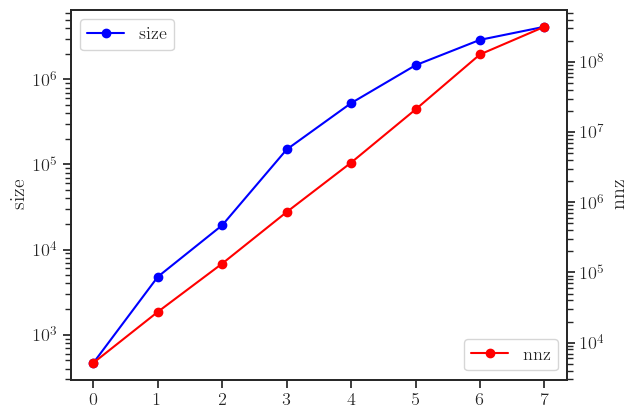

In [3]:
# Sorting data by nnz, plot nnz and matrix size
sort_index = numpy.argsort(cpu_nnz)

fig, ax = plt.subplots()
x = numpy.arange(len(cpu_data_results))
ax.plot(cpu_size[sort_index], '-o', color='blue', label='size')
ax.set_ylabel('size')
ax.set_xticks(x)
#ax.set_xticklabels(names)
ax2 = ax.twinx()
ax2.plot(cpu_nnz[sort_index], '-o', color='red', label='nnz')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
ax2.set_ylabel('nnz')
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)

print('')
for i in range(len(cpu_data_results)):
    print('i: %d, index: %d, name: %s, nnz: %d' % (i, sort_index[i], cpu_names[sort_index[i]], cpu_nnz[i]))

In [4]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]

def find_asymptote_slope(x, y):
    """
    finds slope in y = x**a by fitting a polynomial.
    The is the slope at the end of x (ie, x[-1]).
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    max_degree = 2
    degree = x.size - 1
    if degree > max_degree:
        degree = max_degree
    
    p = numpy.polyfit(log2_x, log2_y, degree)
    dp = numpy.polyder(p)
    
    # Find slope at the end point
    end_point = numpy.sort(log2_x)
    asym_slope = numpy.polyval(dp, end_point[-1])
    
    return asym_slope

data name: Queen_4147
matrix size: 4147110
matrix nnz: 316548962
matrix density: 0.000018
CPU, data type: 32-bit, slope: -0.830493
GPU, data type: 32-bit,  slope: -0.981623
CPU, data type: 64-bit, slope: -0.801877
GPU, data type: 64-bit,  slope: -0.967695
CPU, data type: 128-bit, slope: -0.769195
Plot saved to "benchmark_speed_cores.pdf".


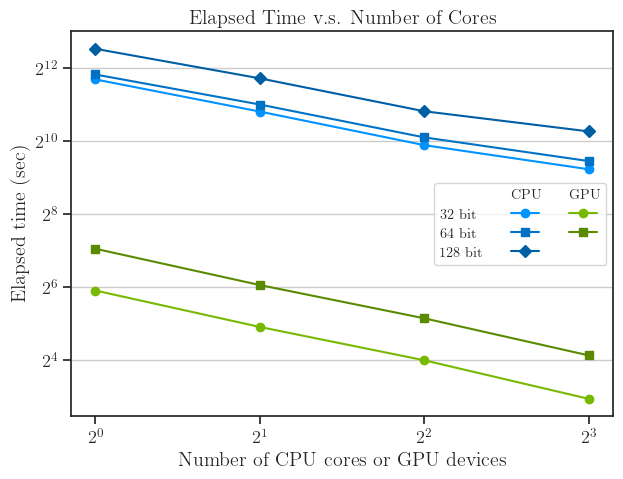

In [5]:
## Plotting Elapsed time vs Cores

# Settings
cpu_data_result = cpu_data_results[7]
gpu_data_result = gpu_data_results[7]
plot_log = True
intel_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
nvidia_color = ['#77B900', '#598A00']              # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

data_name = cpu_data_result['data_name']
print('data name: %s' % data_name)
cpu_type_results = cpu_data_result['type_results']
gpu_type_results = gpu_data_result['type_results']

# Normalie all wall times by cpu wall time of float type
benchmark_wall_time = cpu_data_result['type_results'][0]['cpu_results'][0]['info']['time']['alg_wall_time']

matrix_size = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['size']
matrix_nnz = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['nnz']
matrix_density = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['density']
print('matrix size: %d' % matrix_size)
print('matrix nnz: %d' % matrix_nnz)
print('matrix density: %f' % matrix_density)

fig, ax = plt.subplots(figsize=(7, 5))

# Iterate over 32-bit, 64-bit and 128-bit data
for type_index in range(len(cpu_type_results)):
               
    cpu_type_result = cpu_type_results[type_index]
    gpu_type_result = gpu_type_results[type_index]
    data_type = cpu_type_result['data_type']
    
    cpu_results = cpu_type_result['cpu_results']
    gpu_results = gpu_type_result['gpu_results']

    cpu_num_threads = numpy.zeros((len(cpu_results),), dtype=int)
    cpu_tot_wall_time = numpy.zeros((len(cpu_results),), dtype=float)
    cpu_alg_wall_time = numpy.zeros((len(cpu_results),), dtype=float)
    cpu_cpu_proc_time = numpy.zeros((len(cpu_results),), dtype=float)

    for i in range(len(cpu_results)):
        cpu_num_threads[i]   = cpu_results[i]['info']['device']['num_cpu_threads']
        cpu_tot_wall_time[i] = cpu_results[i]['info']['time']['tot_wall_time']
        cpu_alg_wall_time[i] = cpu_results[i]['info']['time']['alg_wall_time']
        cpu_cpu_proc_time[i] = cpu_results[i]['info']['time']['cpu_proc_time']
        
    slope = find_slope(cpu_num_threads, cpu_alg_wall_time)
    print("CPU, data type: %s, slope: %f" % (data_type + '-bit', slope))

    multi_thread = False
    if not multi_thread:
        cpu_num_cores = cpu_num_threads //2
        
    if plot_log:
        ax.plot(cpu_num_cores, cpu_alg_wall_time,
                markers[type_index], color=intel_color[type_index], label='cpu ' + str(data_type) + '-bit')
    else:
        ax.plot(cpu_num_cores, benchmark_wall_time / cpu_alg_wall_time,
                markers[type_index], color=intel_color[type_index], label='cpu ' + str(data_type) + '-bit')

    if len(gpu_results) > 0:
        gpu_num_gpu_devices = numpy.zeros((len(gpu_results),), dtype=int)
        gpu_tot_wall_time = numpy.zeros((len(gpu_results),), dtype=float)
        gpu_alg_wall_time = numpy.zeros((len(gpu_results),), dtype=float)
        gpu_cpu_proc_time = numpy.zeros((len(gpu_results),), dtype=float)

        for i in range(len(gpu_results)):
            gpu_num_gpu_devices[i] = gpu_results[i]['info']['device']['num_gpu_devices']
            gpu_tot_wall_time[i]   = gpu_results[i]['info']['time']['tot_wall_time']
            gpu_alg_wall_time[i]   = gpu_results[i]['info']['time']['alg_wall_time']
            gpu_cpu_proc_time[i]   = gpu_results[i]['info']['time']['cpu_proc_time']
        
        if gpu_num_gpu_devices.size > 1:
            slope = find_slope(gpu_num_gpu_devices, gpu_alg_wall_time)
            print("GPU, data type: %s,  slope: %f" % (data_type + '-bit', slope))

        if plot_log:
            ax.plot(gpu_num_gpu_devices, gpu_alg_wall_time, markers[type_index],
                color=nvidia_color[type_index], label='gpu ' + str(data_type) + '-bit')
        else:
            ax.plot(gpu_num_gpu_devices, benchmark_wall_time / gpu_alg_wall_time, markers[type_index],
                color=nvidia_color[type_index], label='gpu ' + str(data_type) + '-bit')
        
        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra, extra,
           extra, handles[0], handles[2], handles[4], 
           extra, handles[1], handles[3], extra]
labels = ["", "32 bit", "64 bit", "128 bit",
          "CPU", "", "", "",
          "GPU", "", "", ""]
#handles = [handles[0], handles[2], handles[4], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[1], labels[3]]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='x-small')
if plot_log:
    lg = ax.legend(handles, labels, loc='center right', ncol=3, handletextpad = -2, fontsize='x-small')
else:
    lg = ax.legend(handles, labels, loc='upper left', ncol=3, handletextpad = -2, fontsize='x-small')
#lg.get_frame().set_alpha(None)                                       
#lg.get_frame().set_facecolor((0, 0, 0, 0.0)) 
    
if plot_log:
    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.set_xticks(cpu_num_cores)

if plot_log:
    ax.set_ylabel('Elapsed time (sec)')
    ax.set_title('Elapsed Time v.s. Number of Cores')
else:
    ax.set_ylabel('Speedup')
    ax.set_title('Scalability')

ax.set_xlabel('Number of CPU cores or GPU devices')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
if plot_log:
    filename_svg = 'benchmark_speed_cores' + '.' + extension
else:
    filename_svg = 'benchmark_speed_cores_2' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg)) 

['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_4147']
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_4147']
[     5172     27520    134208    726674   3674625  21005389 127729899
 316548962]
CPU, type: 32-bit, slope: 1.085455
CPU, type: 64-bit, slope: 0.896644
CPU, type: 128-bit, slope: 0.931095
GPU, type: 32-bit, slope: 0.865462
GPU, type: 64-bit, slope: 0.929846
Plot saved to "benchmark_speed_time.pdf".


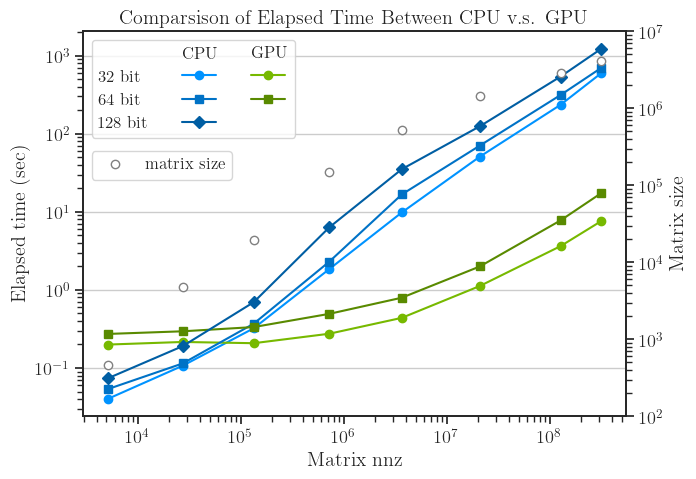

In [6]:
## Plotting Elapsed time vs Matrix Size

# Settings
plot_log = True
intel_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
nvidia_color = ['#77B900', '#598A00']              # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
cpu_data_results_ = cpu_data_results.copy()
gpu_data_results_ = gpu_data_results.copy()

#remove_indices = [0, 1, 2]
remove_indices = []

for index in remove_indices[::-1]:
    del cpu_data_results_[index]
    del gpu_data_results_[index]

# Initialize arrays
num_data = len(cpu_data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
matrix_name = []
matrix_nnz = numpy.zeros((num_data, ), dtype=int)
matrix_density = numpy.zeros((num_data, ), dtype=float)
data_type = numpy.zeros((num_data, num_types), dtype=int)
cpu_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
cpu_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)
gpu_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
gpu_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
gpu_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)

for data_index in range(num_data):

    cpu_data_result = cpu_data_results_[data_index]
    gpu_data_result = gpu_data_results_[data_index]
    matrix_name.append(cpu_data_result['data_name'])
    cpu_type_results = cpu_data_result['type_results']
    gpu_type_results = gpu_data_result['type_results']

    matrix_size[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['size']
    matrix_nnz[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['nnz']
    matrix_density[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['density']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(cpu_type_results)):

        cpu_type_result = cpu_type_results[type_index]
        gpu_type_result = gpu_type_results[type_index]
        data_type[data_index, type_index] = cpu_type_result['data_type']

        cpu_results = cpu_type_result['cpu_results']
        gpu_results = gpu_type_result['gpu_results']

        cpu_num_threads = numpy.zeros((len(cpu_results),), dtype=int)
        cpu_tot_wall_time_ = numpy.zeros((len(cpu_results),), dtype=float)
        cpu_alg_wall_time_ = numpy.zeros((len(cpu_results),), dtype=float)
        cpu_cpu_proc_time_ = numpy.zeros((len(cpu_results),), dtype=float)

        for i in range(len(cpu_results)):
            cpu_num_threads[i]   = cpu_results[i]['info']['device']['num_cpu_threads']
            cpu_tot_wall_time_[i] = cpu_results[i]['info']['time']['tot_wall_time']
            cpu_alg_wall_time_[i] = cpu_results[i]['info']['time']['alg_wall_time']
            cpu_cpu_proc_time_[i] = cpu_results[i]['info']['time']['cpu_proc_time']
            
        # Find which index has the max number of CPU threads
        cpu_max_num_threads_index = numpy.argmax(cpu_num_threads)
        #cpu_max_num_threads_index = numpy.argmin(cpu_num_threads)
        cpu_tot_wall_time[data_index, type_index] = cpu_tot_wall_time_[cpu_max_num_threads_index]
        cpu_alg_wall_time[data_index, type_index] = cpu_alg_wall_time_[cpu_max_num_threads_index]
        cpu_cpu_proc_time[data_index, type_index] = cpu_cpu_proc_time_[cpu_max_num_threads_index]
        
        if len(gpu_results) > 0:
            gpu_num_gpu_devices_ = numpy.zeros((len(gpu_results),), dtype=int)
            gpu_tot_wall_time_ = numpy.zeros((len(gpu_results),), dtype=float)
            gpu_alg_wall_time_ = numpy.zeros((len(gpu_results),), dtype=float)
            gpu_cpu_proc_time_ = numpy.zeros((len(gpu_results),), dtype=float)

            for i in range(len(gpu_results)):
                gpu_num_gpu_devices_[i] = gpu_results[i]['info']['device']['num_gpu_devices']
                gpu_tot_wall_time_[i]   = gpu_results[i]['info']['time']['tot_wall_time']
                gpu_alg_wall_time_[i]   = gpu_results[i]['info']['time']['alg_wall_time']
                gpu_cpu_proc_time_[i]   = gpu_results[i]['info']['time']['cpu_proc_time']

            gpu_max_num_gpu_devices_index = numpy.argmax(gpu_num_gpu_devices_)
            #gpu_max_num_gpu_devices_index = numpy.argmin(gpu_num_gpu_devices_)
            gpu_tot_wall_time[data_index, type_index] = gpu_tot_wall_time_[gpu_max_num_gpu_devices_index]
            gpu_alg_wall_time[data_index, type_index] = gpu_alg_wall_time_[gpu_max_num_gpu_devices_index]
            gpu_cpu_proc_time[data_index, type_index] = gpu_cpu_proc_time_[gpu_max_num_gpu_devices_index]
            
    sort_type_index = numpy.argsort(data_type[data_index, :])
    data_type[data_index, :] = data_type[data_index, sort_type_index]
    cpu_tot_wall_time[data_index, :] = cpu_tot_wall_time[data_index, sort_type_index]
    cpu_alg_wall_time[data_index, :] = cpu_alg_wall_time[data_index, sort_type_index]
    cpu_cpu_proc_time[data_index, :] = cpu_cpu_proc_time[data_index, sort_type_index]
    gpu_tot_wall_time[data_index, :] = gpu_tot_wall_time[data_index, sort_type_index]
    gpu_alg_wall_time[data_index, :] = gpu_alg_wall_time[data_index, sort_type_index]
    gpu_cpu_proc_time[data_index, :] = gpu_cpu_proc_time[data_index, sort_type_index]
    

# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
#abscissa = matrix_size  
abscissa = matrix_nnz

# Set what should be on the y axis of the twin plot.
#ordinate = matrix_density
ordinate = matrix_size
#ordinate = matrix_nnz
        
sorting_index = numpy.argsort(abscissa)
abscissa = abscissa[sorting_index]
ordinate = ordinate[sorting_index]
cpu_alg_wall_time = cpu_alg_wall_time[sorting_index, :]
gpu_alg_wall_time = gpu_alg_wall_time[sorting_index, :]

print(matrix_name)
matrix_name_ = []
for i in sorting_index:
    matrix_name_.append(matrix_name[i])
matrix_name = matrix_name_

print(matrix_name)
print(abscissa)
            
# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

for type_index in range(num_types):
    
    type_ = data_type[0, type_index]
    ax.plot(abscissa, cpu_alg_wall_time[:, type_index], markers[type_index],
            color=intel_color[type_index], label='cpu ' + str(type_) + '-bit')

    if type_ != 128:
        ax.plot(abscissa, gpu_alg_wall_time[:, type_index], markers[type_index],
                color=nvidia_color[type_index], label='gpu ' + str(type_) + '-bit')

# Print slope of CPU
for type_index in range(num_types):
    start_index = 5
    type_ = data_type[0, type_index]
    slope = find_asymptote_slope(abscissa[start_index:], cpu_alg_wall_time[:, type_index][start_index:])
    print("CPU, type: %s, slope: %f" % (str(type_) + '-bit', slope))

# Print slope of GPU
for type_index in range(num_types):
    type_ = data_type[0, type_index]
    if type_ != 128:
        start_index = 5
        slope = find_asymptote_slope(abscissa[start_index:], gpu_alg_wall_time[:, type_index][start_index:])
        print("GPU, type: %s, slope: %f" % (str(type_) + '-bit', slope))
        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra, extra,
           extra, handles[0], handles[2], handles[4], 
           extra, handles[1], handles[3], extra]
labels = ["", "32 bit", "64 bit", "128 bit",
          "CPU", "", "", "",
          "GPU", "", "", ""]

ax2 = ax.twinx()
ax2.plot(abscissa, ordinate, 'o', color='gray', markerfacecolor='white', label='matrix size')

#ax.legend(handles, labels, bbox_to_anchor=(1.15, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='small')
lg1 = ax.legend(handles, labels, loc='upper left', ncol=3, handletextpad = -2, fontsize='small')
#lg1.get_frame().set_alpha(None)                                       
#lg1.get_frame().set_facecolor((0, 0, 0, 0.0))

# ax2.legend(bbox_to_anchor=(1.15, 0.7), loc='upper left', ncol=1, fontsize='small')
lg2 = ax2.legend(bbox_to_anchor=(0, 0.71), loc='upper left', ncol=1, fontsize='small')
#lg2.get_frame().set_alpha(None)                                       
#lg2.get_frame().set_facecolor((0, 0, 0, 0.0)) 
    
plt.xscale('log', base=10)
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.set_ylim([1e2, 1e7])

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(gpu_num_gpu_devices)

ax.set_ylabel('Elapsed time (sec)')
ax2.set_ylabel('Matrix size')
ax.set_title('Comparsison of Elapsed Time Between CPU v.s. GPU')
#ax.set_xlabel('Matrix size')
ax.set_xlabel('Matrix nnz')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'benchmark_speed_time' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg)) 

Plot saved to "benchmark_speed_accuracy.pdf".


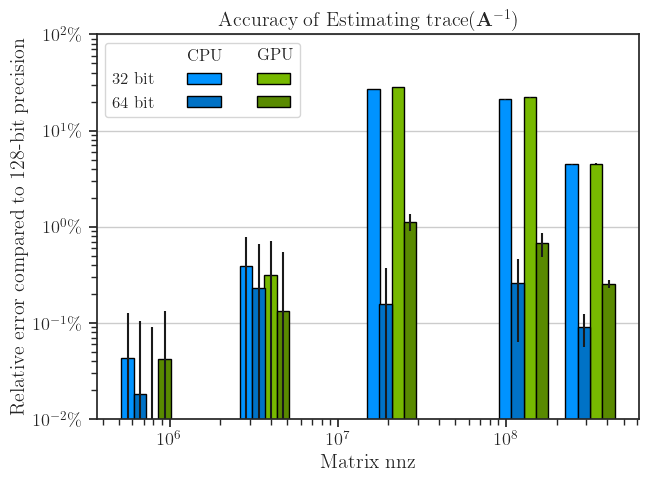

In [7]:
## Plotting Elapsed time vs Matrix Size

# Settings
plot_log = True
intel_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
nvidia_color = ['#77B900', '#598A00']              # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
cpu_data_results_ = cpu_data_results.copy()
gpu_data_results_ = gpu_data_results.copy()

remove_indices = [0, 1, 2]
#remove_indices = []

for index in remove_indices[::-1]:
    del cpu_data_results_[index]
    del gpu_data_results_[index]

# Get number of cou and gpu results from one of the datasets
num_cpu_results = len(cpu_data_results_[0]['type_results'][0]['cpu_results'])
num_gpu_results = len(gpu_data_results_[0]['type_results'][0]['gpu_results'])


# Initialize arrays
num_data = len(cpu_data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
matrix_name = []
matrix_nnz = numpy.zeros((num_data, ), dtype=int)
matrix_density = numpy.zeros((num_data, ), dtype=float)
data_type = numpy.zeros((num_types, ), dtype=int)
cpu_trace = numpy.zeros((num_data, num_types, num_cpu_results), dtype=float)
cpu_error = numpy.zeros((num_data, num_types, num_cpu_results), dtype=float)
gpu_trace = numpy.zeros((num_data, num_types, num_gpu_results), dtype=float)
gpu_error = numpy.zeros((num_data, num_types, num_gpu_results), dtype=float)

gpu_trace[:] = numpy.nan
gpu_error[:] = numpy.nan


for data_index in range(num_data):

    cpu_data_result = cpu_data_results_[data_index]
    gpu_data_result = gpu_data_results_[data_index]
    matrix_name.append(cpu_data_result['data_name'])
    cpu_type_results = cpu_data_result['type_results']
    gpu_type_results = gpu_data_result['type_results']

    matrix_size[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['size']
    matrix_nnz[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['nnz']
    matrix_density[data_index] = cpu_type_results[0]['cpu_results'][0]['info']['matrix']['density']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(cpu_type_results)):

        cpu_type_result = cpu_type_results[type_index]
        gpu_type_result = gpu_type_results[type_index]
        data_type[type_index] = cpu_type_result['data_type']

        cpu_results = cpu_type_result['cpu_results']
        gpu_results = gpu_type_result['gpu_results']

        cpu_num_threads_ = numpy.zeros((len(cpu_results),), dtype=int)

        for i in range(len(cpu_results)):
            cpu_num_threads_[i] = cpu_results[i]['info']['device']['num_cpu_threads']
            cpu_trace[data_index, type_index, i] = cpu_results[i]['trace']
            cpu_error[data_index, type_index, i] = cpu_results[i]['info']['error']['absolute_error']
            
        cpu_sorting_index = numpy.argsort(cpu_num_threads_)
        cpu_trace[:, :, :] = cpu_trace[:, :, cpu_sorting_index]
        cpu_error[:, :, :] = cpu_error[:, :, cpu_sorting_index]
        
        if len(gpu_results) > 0:
            gpu_num_gpu_devices = numpy.zeros((len(gpu_results),), dtype=int)
            
            for i in range(len(gpu_results)):
                gpu_num_gpu_devices[i] = gpu_results[i]['info']['device']['num_gpu_devices']
                gpu_trace[data_index, type_index, i] = gpu_results[i]['trace']
                gpu_error[data_index, type_index, i] = gpu_results[i]['info']['error']['absolute_error']
                
            gpu_sorting_index = numpy.argsort(gpu_num_gpu_devices)
            gpu_trace[:, :, :] = gpu_trace[:, :, gpu_sorting_index]
            gpu_error[:, :, :] = gpu_error[:, :, gpu_sorting_index]

cpu_trace = numpy.mean(cpu_trace, axis=2)
cpu_error = numpy.mean(cpu_error, axis=2)
gpu_trace = numpy.mean(gpu_trace, axis=2)
gpu_error = numpy.mean(gpu_error, axis=2)

# Relative comparison w.r.t 128-bit (in percent)
cpu_trace_relative = numpy.zeros((num_data, num_types), dtype=float)
gpu_trace_relative = numpy.zeros((num_data, num_types), dtype=float)
cpu_error_relative = numpy.zeros((num_data, num_types), dtype=float)
gpu_error_relative = numpy.zeros((num_data, num_types), dtype=float)
percent = 100.0


for data_index in range(num_data):
    benchmark_cpu_trace = numpy.abs(cpu_trace[data_index, -1])
    benchmark_gpu_trace = numpy.abs(gpu_trace[data_index, -1])
    
    for type_index in range(num_types):
        cpu_trace_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_trace[data_index, type_index] - benchmark_cpu_trace) / benchmark_cpu_trace
        gpu_trace_relative[data_index, type_index ] = percent * \
            numpy.abs(gpu_trace[data_index, type_index] - benchmark_cpu_trace) / benchmark_cpu_trace
        
        cpu_error_relative[data_index, type_index ] = percent * \
            numpy.abs(cpu_error[data_index, type_index]) / benchmark_cpu_trace
        gpu_error_relative[data_index, type_index ] = percent * \
            numpy.abs(gpu_error[data_index, type_index]) / benchmark_cpu_trace

    
# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
#abscissa = matrix_size  
abscissa = matrix_nnz

width = 0.17
logsp = numpy.logspace(-width/1.55, width/1.55, 4)
cpu_widths = logsp[:2]
gpu_widths = logsp[2:]

for type_index in range(num_types-1):
    
    type_ = data_type[type_index]
    x = cpu_widths[type_index]*abscissa
    ax.bar(x, cpu_trace_relative[:, type_index], yerr=cpu_error_relative[:, type_index],
           width=width*x, edgecolor='black',
       color=intel_color[type_index], label='cpu ' + str(type_) + '-bit')
    
    if type_ != 128:
        x = gpu_widths[type_index]*abscissa
        ax.bar(x, gpu_trace_relative[:, type_index], yerr=gpu_error_relative[:, type_index],
               width=width*x, edgecolor='black',
           color=nvidia_color[type_index], label='gpu ' + str(type_) + '-bit')

        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra,
           extra, handles[0], handles[2], 
           extra, handles[1], handles[3]]
labels = ["", "32 bit", "64 bit",
          "CPU", "", "",
          "GPU", "", ""]
#handles = [handles[0], handles[2], handles[4], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[1], labels[3]]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='small')
lg3 = ax.legend(handles, labels, loc='upper left', ncol=3, handletextpad = -2, fontsize='small')
#lg3.get_frame().set_alpha(None)                                       
#lg3.get_frame().set_facecolor((0, 0, 0, 0.0)) 
    
plt.xscale('log', base=10)
plt.yscale('log', base=10)

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(data_type)
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=2, xmax=100))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))
ax.set_ylim([1e-2, 1e2])


ax.set_ylabel('Relative error compared to 128-bit precision')
ax.set_title('Accuracy of Estimating $\mathrm{trace}(\mathbf{A}^{-1})$')

ax.set_xlabel('Matrix nnz')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'benchmark_speed_accuracy' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

In [8]:
data_index = 3

print('32-bit')
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][0]['cpu_results'][2]['trace'])
print('\n64-bit')
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][1]['cpu_results'][2]['trace'])
print('\n128-bit')
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][0]['trace'])
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][1]['trace'])
print(cpu_data_results[data_index]['type_results'][2]['cpu_results'][2]['trace'])

32-bit
20588.744
20588.39
20594.287

64-bit
20578.36898267296
20587.616319085722
20583.194770137332

128-bit
20580.124545639788577
20575.312272067984134
20579.043161374133863


In [9]:
data_index = 3

print('32-bit')
print(gpu_data_results[data_index]['type_results'][0]['gpu_results'][0]['trace'])
print(gpu_data_results[data_index]['type_results'][0]['gpu_results'][1]['trace'])
print(gpu_data_results[data_index]['type_results'][0]['gpu_results'][2]['trace'])
print('\n64-bit')
print(gpu_data_results[data_index]['type_results'][1]['gpu_results'][0]['trace'])
print(gpu_data_results[data_index]['type_results'][1]['gpu_results'][1]['trace'])
print(gpu_data_results[data_index]['type_results'][1]['gpu_results'][2]['trace'])

32-bit
20575.705
20591.842
20568.69

64-bit
20589.761387510756
20591.241158252793
20582.404938292246
